# Siggi Example

### Import necessary code from repo

In [1]:
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import BandpassDict
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Set up filter object and get example spectra

In [3]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

### Define redshift prior

In [4]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**1.5)))

In [5]:
# Shows the total entropy for 2 SEDs with equal weighting
entropy = -1. * .5 * np.sum(prior_z(np.arange(0.05, 2.51, .05)) * np.log2(.5 * prior_z(np.arange(0.05, 2.51, .05))))
print(entropy*2.)

5.80714775122


### Set up a siggi object with the SEDs, the SED weights, the prior, and the redshift binning defined.

In [9]:
sig_example = siggi([red_spec, blue_spec], [0.5, 0.5], prior_z,
                    z_min=0.00, z_max=2.5, z_steps=51)

### Can also include a set of filters that are static and not moved in the optimization

Here we use the LSST *ugrizy* filters

In [10]:
frozen_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassDir='../siggi/data/lsst_baseline_throughputs/')
# To make things more interesting we will just use the 'u' and 'g' filters.
frozen_dict = BandpassDict(frozen_dict.values()[:2], frozen_dict.keys()[:2])

### Run optimization

In [11]:
%%time
random_state = np.random.RandomState(17)
num_filters = 2
set_ratio = 1.0
res = sig_example.optimize_filters(num_filters=num_filters,
                                   filt_min=300., filt_max=1100.,
                                   set_ratio=set_ratio,
                                   system_wavelen_max=1200.,
                                   n_opt_points=25,
                                   optimizer_verbosity=10,
                                   procs=4, acq_func_kwargs_dict={'kappa':3},
                                   frozen_filt_dict=frozen_dict, frozen_filt_eff_wavelen=[365, 477],
                                   starting_points = None,
                                   rand_state = random_state)

[(300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0), (300.0, 1100.0)] [[300.0, 700.0, 700.0, 1100.0], [300.0, 500.0, 500.0, 700.0], [700.0, 900.0, 900.0, 1100.0], [354.3202865530331, 453.21662955799587, 535.73200214968779, 724.46940448423527], [760.48231500242719, 810.01671683490872, 825.0668174206844, 929.5883679999306], [331.25033295109318, 348.03574425230829, 586.25088358683911, 1056.5465494547261], [340.95493249636297, 821.9348923725239, 991.2336828369688, 1001.8324209184242], [526.39052868559293, 686.82289944800164, 741.40109490790019, 778.01060259124074], [538.18057464141725, 616.8379488376213, 749.20712426108889, 930.96056774311967], [344.19308017265899, 415.1231366202623, 420.72535553654166, 634.7875082767016]]
[[300.0, 700.0, 700.0, 1100.0], [300.0, 500.0, 500.0, 700.0], [700.0, 900.0, 900.0, 1100.0], [354.3202865530331, 453.21662955799587, 535.73200214968779, 724.46940448423527], [760.48231500242719, 810.01671683490872, 825.0668174206844, 929.5883679999306], [331.2503329510931

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:   29.0s remaining:   29.0s


[331.25033295109318, 348.03574425230829, 586.25088358683911, 1056.5465494547261] 0.570651562702
[340.95493249636297, 821.9348923725239, 991.2336828369688, 1001.8324209184242] 0.682725194009


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   29.9s remaining:   12.8s


[526.39052868559293, 686.82289944800164, 741.40109490790019, 778.01060259124074] 1.02058047215
[538.18057464141725, 616.8379488376213, 749.20712426108889, 930.96056774311967] 1.14698600218
[344.19308017265899, 415.1231366202623, 420.72535553654166, 634.7875082767016] 0.325890219237


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   43.4s finished


-1.48465640335 10
[513.51770995046718, 906.23477802212051] [[300.0, 300.0, 727.03541990093436, 727.03541990093436], [712.46955604424102, 712.46955604424102, 1100.0, 1100.0]]
[660.28898706253756, 1000.0000008239963] [[420.57797843723449, 420.57797843723449, 899.99999568784062, 899.99999568784062], [900.00000164799258, 900.00000164799258, 1100.0, 1100.0]]
[684.88779950490232, 843.87912881185014] [[671.24300411753188, 671.24300411753188, 698.53259489227275, 698.53259489227275], [782.11893843765336, 782.11893843765336, 905.63931918604692, 905.63931918604692]]
4
[700.0, 907.04374199260985] [[300.0, 300.0, 1100.0, 1100.0], [714.08748398521971, 714.08748398521971, 1100.0, 1100.0]]
5
Random Points Used: 0
[420.57797843723449, 899.99999568784062, 900.00000164799258, 1100.0] 1.36592233552
[300.0, 1100.0, 714.08748398521971, 1100.0] 0.876030154084
[671.24300411753188, 698.53259489227275, 782.11893843765336, 905.63931918604692] 0.965792517034


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.4s remaining:   14.4s


[300.0, 727.03541990093436, 712.46955604424102, 1100.0] 1.54330693327


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   14.6s finished


-1.54330693327 14
[522.95690073097194, 912.36428731493015] [[300.0, 300.0, 745.91380146194388, 745.91380146194388], [724.7285746298603, 724.7285746298603, 1100.0, 1100.0]]
[522.92502571900377, 900.49365577723472] [[329.16459765443443, 329.16459765443437, 716.68545378357317, 716.68545378357317], [700.98731155446944, 700.98731155446944, 1100.0, 1100.0]]
[518.42864525189884, 899.96105921742867] [[339.36868197140655, 339.3686819714066, 697.48860853239103, 697.48860853239103], [699.92211843485734, 699.92211843485734, 1100.0, 1100.0]]
[499.72900462066156, 829.91144583425648] [[300.72038499721828, 300.72038499721828, 698.73762424410484, 698.73762424410484], [693.4958908398005, 693.4958908398005, 966.32700082871247, 966.32700082871247]]
4
Random Points Used: 0
[329.16459765443443, 716.68545378357317, 700.98731155446944, 1100.0] 1.51993143254
[300.0, 745.91380146194388, 724.7285746298603, 1100.0] 1.56874612664


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   14.5s remaining:   14.5s


[300.72038499721828, 698.73762424410484, 693.4958908398005, 966.32700082871247] 1.42311416252
[339.36868197140655, 697.48860853239103, 699.92211843485734, 1100.0] 1.48291429699


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s finished


-1.56874612664 18
[536.42567560380996, 911.7162811769125] [[300.0, 300.0, 772.85135120761993, 772.85135120761993], [723.43256235382501, 723.43256235382501, 1100.0, 1100.0]]
[521.74702033582912, 911.94566200906434] [[300.0, 300.0, 743.49404067165824, 743.49404067165824], [723.89132401812856, 723.89132401812867, 1100.0, 1100.0]]
[603.11032550786126, 836.16759920393747] [[500.31632784352587, 500.31632784352587, 705.90432317219665, 705.90432317219665], [656.72614406033586, 656.72614406033586, 1015.6090543475391, 1015.6090543475391]]
4
[536.42566584157044, 911.71631633733068] [[300.0, 300.0, 772.85133168314087, 772.85133168314087], [723.43263267466148, 723.43263267466136, 1100.0, 1100.0]]
5
Random Points Used: 0
[300.0, 743.49404067165824, 723.89132401812856, 1100.0] 1.56593984953


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   15.4s


[300.0, 772.85135120761993, 723.43256235382501, 1100.0] 1.56576978421


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   16.1s remaining:   16.1s


[500.31632784352587, 705.90432317219665, 656.72614406033586, 1015.6090543475391] 1.47601930266
[300.0, 772.85133168314087, 723.43263267466148, 1100.0] 1.56576978421


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   16.6s finished


-1.56874612664 22
[532.05911204777158, 925.79842993468196] [[300.0, 300.00000000000006, 764.11822409554316, 764.11822409554304], [751.59685986936393, 751.59685986936393, 1100.0, 1100.0]]
[531.8344455091767, 830.94826190533354] [[497.37073119290659, 497.37073119290665, 566.29815982544676, 566.29815982544676], [699.12709145538929, 699.12709145538929, 962.76943235527779, 962.76943235527779]]
4
[573.38171172466423, 918.54188860646582] [[374.17585295998447, 374.17585295998447, 772.58757048934399, 772.58757048934399], [737.08377721293152, 737.08377721293164, 1100.0, 1100.0]]
[595.61779791272897, 867.22650313370605] [[487.57955127726416, 487.5795512772641, 703.6560445481939, 703.6560445481939], [634.45300626741209, 634.45300626741209, 1100.0, 1100.0]]
6
Random Points Used: 0
[300.0, 764.11822409554304, 751.59685986936393, 1100.0] 1.59141105955
[497.37073119290659, 566.29815982544676, 699.12709145538929, 962.76943235527779] 0.860799068115


[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   14.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   15.0s remaining:   15.0s


[374.17585295998447, 772.58757048934399, 737.08377721293152, 1100.0] 1.58468928317
[487.57955127726416, 703.6560445481939, 634.45300626741209, 1100.0] 1.4618185438


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   15.6s finished


-1.59141105955 26
CPU times: user 3min 2s, sys: 30min 43s, total: 33min 45s
Wall time: 2min 43s


### Find the best results

In [12]:
min_idx = np.argmin(res.yi)

In [13]:
best_pt = res.Xi[min_idx]

In [14]:
best_val = np.min(res.yi)

In [15]:
print(best_pt, best_val)

[300.0, 764.11822409554304, 751.59685986936393, 1100.0] -1.59141105955


### Plot with Siggi's plotting code

In [16]:
red_spec.redshiftSED(0.5)
blue_spec.redshiftSED(0.5)
sig_plot = plotting([red_spec, blue_spec], best_pt, set_ratio=1.0,
                    frozen_filt_dict=frozen_dict, frozen_filt_eff_wavelen=[365, 477],
                    sed_mags=22.0)

#### Let's first make a plot of the new filters along with the filters we've frozen in place. For reference we'll also include the SEDs at redshift z=0.5.

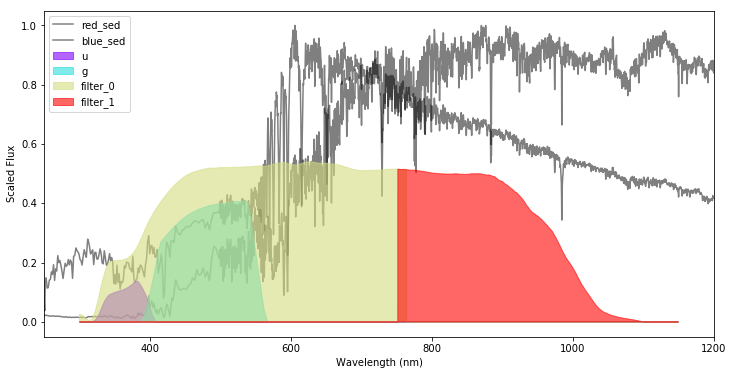

In [17]:
fig = sig_plot.plot_filters()
plt.legend(['red_sed', 'blue_sed'] + sig_plot.filter_dict.keys())

#### We can also look at a color-color plot of the new color values for each sed as it increases in redshift and the error bars on the colors

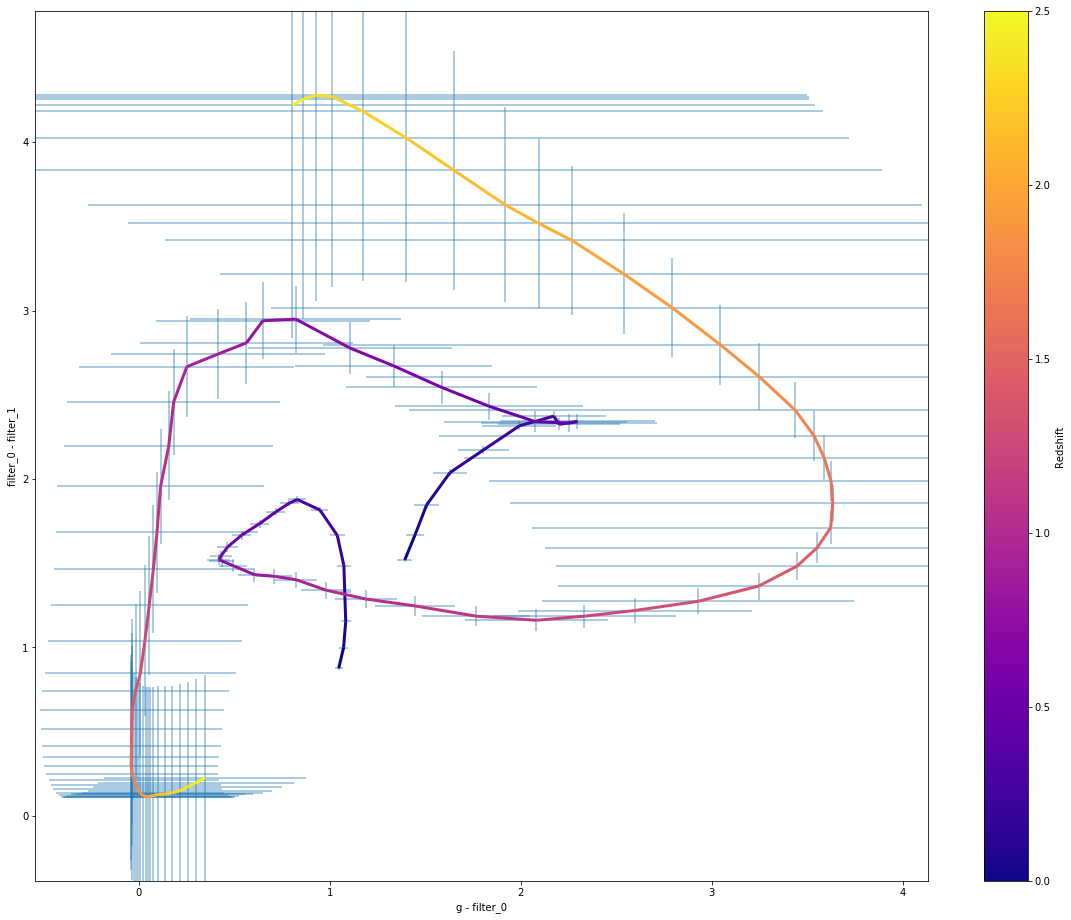

In [20]:
fig = plt.figure(figsize=(20,16))
fig = sig_plot.plot_color_color(['g', 'filter_0', 'filter_0', 'filter_1'],
                                np.linspace(0.00, 2.5, 51), fig=fig, include_err=True)

../siggi/siggiBase.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  frac_a1 = half_area/a1
../siggi/siggiBase.py:200: RuntimeWarning: invalid value encountered in double_scalars
  length_ha = np.sqrt(frac_a1*(filt[1] - filt[0])**2.)


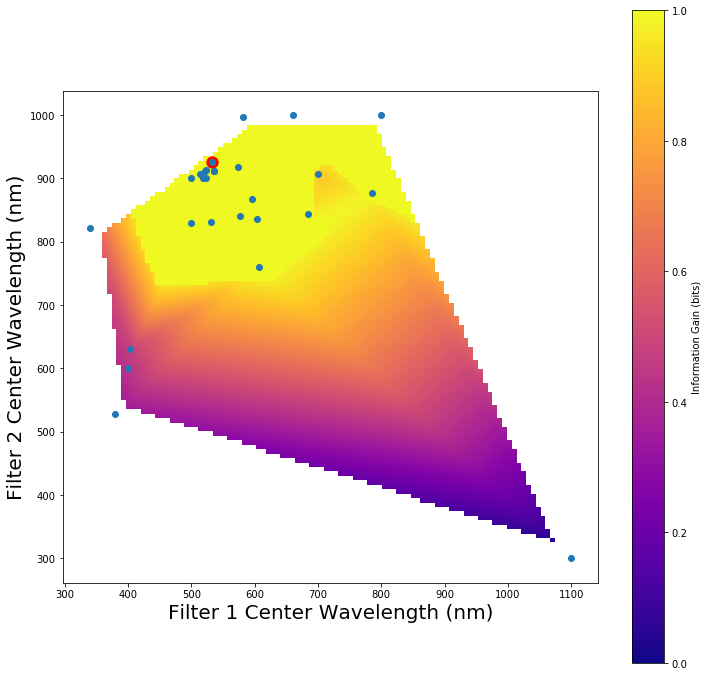

In [21]:
# Preliminary Feature #
# Information Gain Space plotting for multiple filters #
fig = plt.figure(figsize=(12,12))
xi, yi = sig_plot.plot_ig_space(res.Xi, np.abs(res.yi), [0,1], return_centers=True)
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)')
plt.scatter(best_pt[0] + (best_pt[1]-best_pt[0])/2., best_pt[2] + (best_pt[3]-best_pt[2])/2., c='r', s=128)
plt.scatter(xi, yi)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)